## Imports 📦

In [88]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string

In [153]:
from matplotlib import pyplot as plt

In [89]:
warnings.filterwarnings('ignore')

## Load Data 💿

In [90]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [91]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [92]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()

In [93]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
en_filtered_comments = []

for comment in en_comment:
    # remove word starts with @
    comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
    # remove punctuations
    comment = comment.translate(str.maketrans('', '', string.punctuation))

    # remove stopwords
    words = nltk.word_tokenize(comment)
    filtered_comment = [word for word in words if word.lower() not in en_stop_words]
    filtered_comment = ' '.join(filtered_comment)
    filtered_comment = comment
    en_filtered_comments.append(filtered_comment)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aorawancraprayoon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aorawancraprayoon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
es_stop_words = set(stopwords.words('spanish'))
es_filtered_comments = []

for comment in es_comment:
    # remove word starts with @
    comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
    # remove punctuations
    comment = comment.translate(str.maketrans('', '', string.punctuation))

    # remove stopwords
    words = nltk.word_tokenize(comment)
    filtered_comment = [word for word in words if word.lower() not in es_stop_words]
    filtered_comment = ' '.join(filtered_comment)
    filtered_comment = comment
    es_filtered_comments.append(filtered_comment)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [95]:
pip install laserembeddings

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [97]:
!/usr/bin/python3 -m laserembeddings download-models


✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [98]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')

## Emoji Embeddings using Emoji2Vec

In [99]:
from gensim.models import KeyedVectors

en_emoji = en_df['emoji list'].to_list()

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

# Initialize a list to store emoji embeddings
en_emoji_embedding = []

for emoji_list in en_emoji:
    emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
    for emoji in emoji_list:
        try:
            emoji_list_embedding.append(emoji_model[emoji])
        except KeyError:
            pass
    if len(emoji_list_embedding) != 0:
        emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
    en_emoji_embedding.append(emoji_list_embedding)


en_max_size = max(len(arr) for arr in en_emoji_embedding)
en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
en_emoji_array = np.vstack(en_padded_arrays)

In [100]:
en_emoji_array.shape

(280, 3600)

In [101]:
en_text_array.shape

(280, 1024)

In [102]:
es_emoji = es_df['emoji list'].to_list()

es_emoji_embedding = []

for emoji_list in es_emoji:
    emoji_list_embedding = []  # Initialize a list for embeddings of each emoji list
    for emoji in emoji_list:
        try:
            emoji_list_embedding.append(emoji_model[emoji])
        except KeyError:
            pass
    if len(emoji_list_embedding) != 0:
        emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)

    es_emoji_embedding.append(emoji_list_embedding)

es_max_size = max(len(arr) for arr in es_emoji_embedding)
es_padded_arrays = [np.pad(arr, (0, es_max_size - len(arr)), 'constant') for arr in es_emoji_embedding]
es_emoji_array = np.vstack(es_padded_arrays)

## Concatenate the text embeddings and emoji embeddings (if there are more than one emoji, we concatenate all of them)

In [103]:
import numpy as np

# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

### Padded_arrays may affect clustering result. What else can we do to normalize data with varying size of embeddings?

In [104]:
len(en_embeddings[0])

4624

In [105]:
len(es_embeddings[0])

9424

## Try clustering using minibatch Kmeans -- concatenated word + emoji embeddings

In [49]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Determine optimal number of clusters

#### Distortion Score Elbow
- based on calculating the Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish.

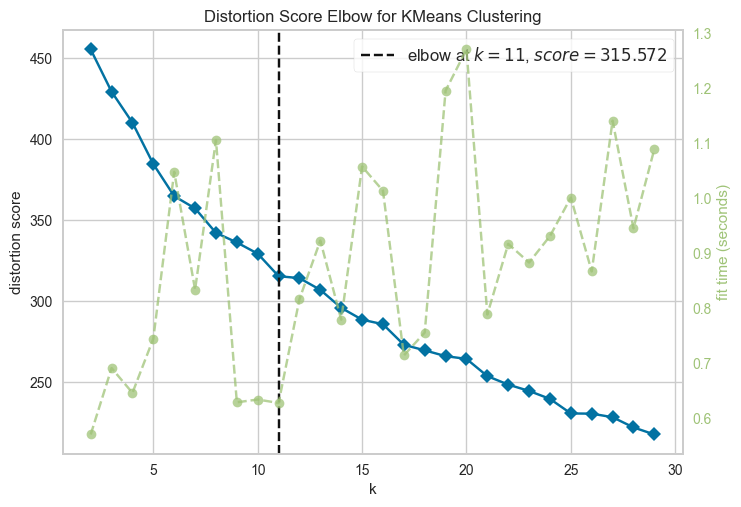

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [157]:
# referenced https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(en_embeddings)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

#### Silhouette Coefficient Method

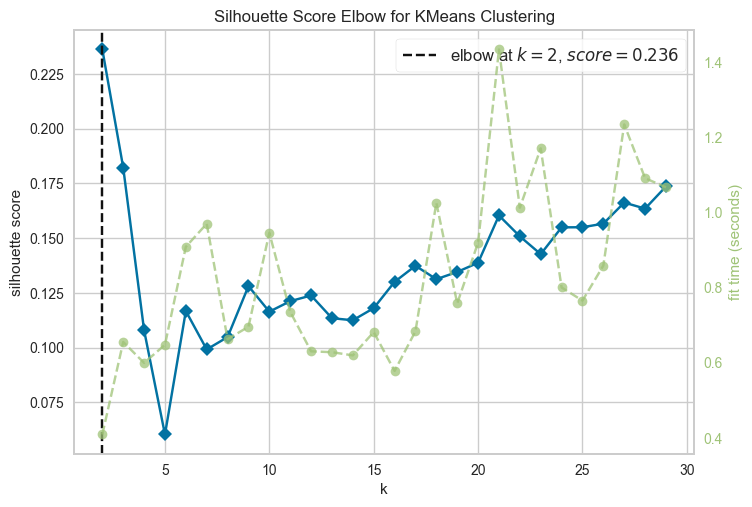

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [158]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(en_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### Calinski-Harabasz Index

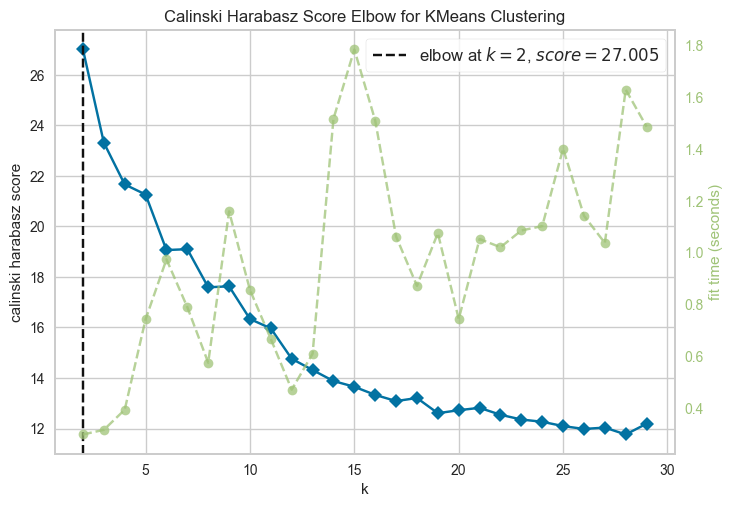

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [160]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(en_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Clustering Functions

In [107]:
# code from https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [190]:
def apply_cluster(lang_embeddings, lang_df, lang_filtered_comments, k):
    clustering, cluster_labels = mbkmeans_clusters(
        X=lang_embeddings,
        k=k,
        mb=500,
        print_silhouette_values=True,
    )
    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "tokens": [" ".join(text) for text in lang_filtered_comments],
        "cluster": cluster_labels
    })
    return df_clusters

### English Results

In [177]:
en_df_clusters = apply_cluster(en_embeddings, en_df, en_filtered_comments, 11)

For n_clusters = 11
Silhouette coefficient: 0.14
Inertia:322.4774092846409
Silhouette values:
    Cluster 3: Size:16 | Avg:0.33 | Min:0.02 | Max: 0.40
    Cluster 2: Size:14 | Avg:0.30 | Min:0.17 | Max: 0.39
    Cluster 8: Size:7 | Avg:0.30 | Min:0.11 | Max: 0.38
    Cluster 0: Size:76 | Avg:0.26 | Min:0.04 | Max: 0.38
    Cluster 9: Size:7 | Avg:0.26 | Min:0.19 | Max: 0.29
    Cluster 10: Size:13 | Avg:0.19 | Min:0.00 | Max: 0.32
    Cluster 5: Size:15 | Avg:0.12 | Min:-0.06 | Max: 0.28
    Cluster 1: Size:12 | Avg:0.07 | Min:-0.05 | Max: 0.14
    Cluster 7: Size:18 | Avg:0.01 | Min:-0.08 | Max: 0.06
    Cluster 4: Size:24 | Avg:0.00 | Min:-0.05 | Max: 0.06
    Cluster 6: Size:78 | Avg:-0.00 | Min:-0.11 | Max: 0.07


Top 3 English clusters

In [180]:
en_df_clusters[en_df_clusters['cluster']==3]['text'].tolist()

['This nikka sick wit it🔥😂',
 'The France 🇫🇷 is on Fire 🔥',
 'dats literally my dad 🔥',
 '@pure_sh1thousery we are winer❤️❤️🔥🇮🇷🇮🇷🇮🇷🇮🇷',
 'Musiala all the way🔥',
 'Rushford 🔥',
 "BRAZIL VS SERBIA....THE GAME BRAZIL PLAYED AGAINST A TEAM LIKE SERBIA WHICH HAD SUCH AN AMAZING DEFENCE🔥❤️ EVEN THOUGH I'M NOT A BRAZIL FAN😍 BUT WHATEVER FRANCE🔥❤️MY TEAMMMM😍MBAPPE 💗",
 'Nice game 🔥',
 '🇹🇳 ❤️🔥 should be proud 👏',
 'Wow very gorgeous ❤️🔥😍',
 'Congratulations 🔥👏',
 'Cool🔥',
 'The big and champions France in Qatar2022🔥',
 '@farzad_1818 I like both team but wowwww Maroccco 🔥',
 '@m.a.l.e.k.a.n.o_jr Just wait🔥',
 'Well played Morocco’s number 7 a good play maker enjoyed his movments 🔥 see you next time fight for 3rd 👏']

In [181]:
en_df_clusters[en_df_clusters['cluster']==2]['text'].tolist()

['@jan_schawe to what 😂😂😂😂😂',
 'One Love 🌈✖ 😂😂😂 one two ✔ 🤭🤭🤭',
 'Bro was forced to do it😂😂😂😂😂',
 "@mounia.kr__ 😂😂😂 that's the fact about the football.. you people are still too backward(refused) to accept modern changes about modern football.. keep on believing on ancient believes😂😂... No matter the shades, Algeria have not wil never be part of the Qatar world cup😂. NEVER!!. Cameroon is a football giant with Africa and world records. there is nothing you can do about it so chill and enjoy football 😂",
 '@tina.f.aoun @gretta.khoury_ bs rebho aalaykun😂😂😂😂😂',
 'All I watch was pessi missing a pen a 3 big chances in front of the goal 😂😂😂😂👏 small game player',
 '@mr_yasser25 yeah but u didn’t qualify 😂😂😂😂😂 try again in the next 4yrs 😂😂😂',
 '@88godiswithme 😂😂😂😂😂😂😂 congratulations!!',
 '@spasho05 😂😂😂😂',
 '@enkiduh how about now 😂😂😂😂😂 ❤️❤️❤️❤️❤️',
 'You people should leave the innocent referee alone.He was paid by the English team to work on their favour by giving them 2 undeserving penalties

In [182]:
en_df_clusters[en_df_clusters['cluster']==8]['text'].tolist()

['@itisjuanderful AAJAA POR NO PERMITIR GAYS EN LA COPA MUNDIAL YO LO VEO EXCELENTE👏🔥',
 'Brilliant player 👏🔥',
 'Shout out to my boy @richarlison with the best goal in this world cup 2022👏🔥🇧🇷🇧🇷🇧🇷🇧🇷',
 'That throw was lit👏🔥',
 "Thank you for entertaining me Japan, I'm waiting for the excitement again in four years👏❤️\u200d🔥🇯🇵🇯🇵❤️\u200d🔥",
 'Messi wins the this exciting wc!!! 👏🔥❤️\u200d🔥',
 'Argentina vs France 👏🔥👏🔥👏 Greatest rivalry']

### Spanish Results

Top 3 Spanish clusters

In [191]:
es_df_clusters = apply_cluster(es_embeddings, es_df, es_filtered_comments, 11)

For n_clusters = 11
Silhouette coefficient: 0.12
Inertia:313.199978668993
Silhouette values:
    Cluster 10: Size:31 | Avg:0.52 | Min:0.46 | Max: 0.57
    Cluster 9: Size:51 | Avg:0.43 | Min:0.16 | Max: 0.51
    Cluster 5: Size:13 | Avg:0.40 | Min:0.26 | Max: 0.47
    Cluster 3: Size:2 | Avg:0.23 | Min:0.22 | Max: 0.23
    Cluster 6: Size:18 | Avg:0.13 | Min:-0.15 | Max: 0.23
    Cluster 2: Size:15 | Avg:0.09 | Min:-0.05 | Max: 0.20
    Cluster 8: Size:17 | Avg:0.08 | Min:-0.12 | Max: 0.25
    Cluster 4: Size:25 | Avg:0.07 | Min:-0.21 | Max: 0.20
    Cluster 0: Size:7 | Avg:-0.07 | Min:-0.11 | Max: -0.00
    Cluster 7: Size:34 | Avg:-0.10 | Min:-0.27 | Max: 0.11
    Cluster 1: Size:67 | Avg:-0.18 | Min:-0.27 | Max: -0.06


In [193]:
es_df_clusters[es_df_clusters['cluster']==10]['text'].tolist()

['@lauhernandezchavez La Payasada Les salió caro 😂',
 'Poor guy 😂',
 'Ecuador los hizo bailar los humilló y supuestamente este quedé como mejor jugador 😂 tras que anulan  un gol legítimo, también meten mano en el mejor jugador cuando todo el mundo se dió cuenta perfectamente que Ecuador los superó, que descarados que son',
 '😂 Ronaldo',
 'Se mueve más una cucaracha con baygon😂',
 '@jomiguelrivera el gol del siglo se lo hicimos a italia😂',
 'Que buen negocio el de nuestra selección 😂',
 'Lo re sentamos al polaco😂',
 'Jajajaja ni ganas de buscar el buscador 😂',
 'El equipo que ganó x que Portugal se dejo ganar lo mismo hizo españa😂',
 '@salvalopz4 mira las estrellas que tiene cada escudo y despues decime quien es hijo de quien 😂',
 '@vlz.matthew_ sos muy chico al lado de Uruguay ni al mundial clasificas 😂',
 '@romanruizdiazok los argentinos estan tan ilusionados😂',
 '@abderazak_ot vale, el caso es que la derrota era merecida, pero no estas para bromear, repito que Marruecos no tiene ni t

In [194]:
es_df_clusters[es_df_clusters['cluster']==9]['text'].tolist()

['@carlos_arte24 no se porque but I love the jersey 🥶',
 'Ecuador! 🇪🇨🇪🇨🇪🇨🇪🇨❤❤',
 'Cambien la bandera, somos Ecuador 🇪🇨☝🏻',
 '@jctorr130 1-1🤫🤫🤫🤫',
 'Go Ecuador 🇪🇨❤️',
 '🤫 tranki nomás, todavía no está todo dicho',
 'Vamos Perú ❤️',
 'Vamos Ecuador ❤️❤️',
 'Vamos Marruecos ❤️',
 'Eden ❤️',
 'Mechico 🤏🏼',
 'Vamooo Halcón 🦅 🇺🇾',
 '@queenfir_ marocco ❤️❤️',
 'Ufff ese uruguayo ❤️',
 'Anótalo papi .....Vamos Ecuador 🇪🇨🥰❤️❤️',
 '@mindimalist aquí estamos mana, apoyándolos hasta el final ❤️',
 '_Marocoo🇲🇦🫀_',
 'El gol del siglo 🇨🇷\U0001fae1',
 '@zeferinooo.ema más que orgullosa de mi país... Cuando sepan lo que pesa una Copa del Mundo podrán hablar de fútbol ✌️🇺🇾',
 'Desde ahi nunca se lavó la mano aaa❤️\u200d🩹',
 '#YNWA te amamos Capitán ❤️',
 'Ecuador 🇪🇨 ❤️#win',
 '@luisitorres_ sí 🥵',
 'Eso Japón, fuera Alemania ❤️',
 '@fabilleao cállate la boca anda🤫🤫',
 '@lucaasperee ya quisieras Estar en Texas que de echol Se come Súper Bien y Se gana mucho $$$& te lo recomiendo y que están ustedes esta 

In [195]:
es_df_clusters[es_df_clusters['cluster']==5]['text'].tolist()

['Con todo maes 🔥🇨🇷',
 'Te amamos @yosoy8a 🇲🇽🔥',
 'Vamos España 🔥',
 '@hoonjy ustedes, si esos tiros no hirviesen pegado en el palo uffff🔥',
 'Toda mí fe para la Argentina 🔥',
 '@borenia grs!!! 🔥🙌❤️ futbol es fútbol',
 '@pablogavi buena suerte🔥',
 'Aidouni🔥❤️',
 'Que partidazo el de este señor🔥',
 'Argentina 🔥💚',
 'Los trios siempre son buenos bro 🔥😉',
 'Fue un partido exquisito 🔥',
 'Argentina, Alvares🔥']